### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean
import tensorflow as tf

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_ASTER.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = np.float16(arrFeatures)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array(arrFeatures[band-1, :, :], f'Band {band}')

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output()), _…

### Generating chips

In [4]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

# create chips using pyrsgis
features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=5, y_size=5)

### Loading the training dataset (manual)

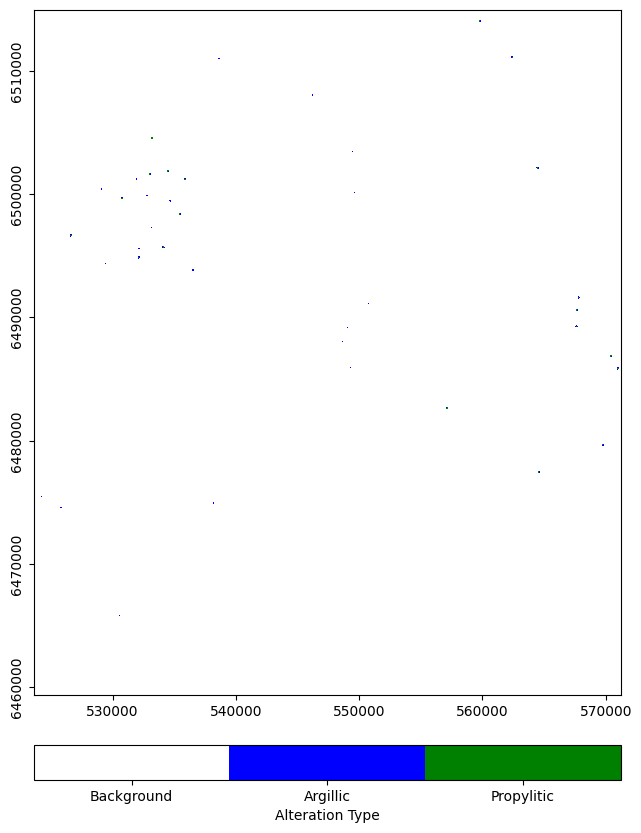

In [5]:
positiveLabel_file = './BrokenHill_ASTER_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [7]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/100
134/134 [==============================] - 1s 4ms/step - loss: 0.8532 - accuracy: 0.5771 - val_loss: 0.4030 - val_accuracy: 0.8752
Epoch 2/100
134/134 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8569 - val_loss: 0.1882 - val_accuracy: 0.9447
Epoch 3/100
134/134 [==============================] - 0s 3ms/step - loss: 0.2095 - accuracy: 0.9357 - val_loss: 0.1584 - val_accuracy: 0.9442
Epoch 4/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1647 - accuracy: 0.9451 - val_loss: 0.1477 - val_accuracy: 0.9491
Epoch 5/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.9557 - val_loss: 0.0758 - val_accuracy: 0.9770
Epoch 6/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9634 - val_loss: 0.0688 - val_accuracy: 0.9776
Epoch 7/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1009 - accuracy: 0.9716 - val_loss: 0.0884 - val_accuracy: 0.9688

Epoch 58/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.9833 - val_loss: 0.0547 - val_accuracy: 0.9841
Epoch 59/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 0.9864 - val_loss: 0.0875 - val_accuracy: 0.9683
Epoch 60/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.0375 - val_accuracy: 0.9885
Epoch 61/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.9784 - val_loss: 0.0757 - val_accuracy: 0.9781
Epoch 62/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9815 - val_loss: 0.0611 - val_accuracy: 0.9819
Epoch 63/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0791 - accuracy: 0.9761 - val_loss: 0.0412 - val_accuracy: 0.9863
Epoch 64/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0561 - accuracy: 0.9848 - val_loss: 0.0338 - val_accuracy:

Epoch 64/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9826 - val_loss: 0.0988 - val_accuracy: 0.9683
Epoch 65/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 0.9819 - val_loss: 0.0370 - val_accuracy: 0.9891
Epoch 66/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9833 - val_loss: 0.0511 - val_accuracy: 0.9836
Epoch 67/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.9789 - val_loss: 0.0505 - val_accuracy: 0.9814
Epoch 68/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9822 - val_loss: 0.0624 - val_accuracy: 0.9819
Epoch 69/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0453 - val_accuracy: 0.9874
Epoch 70/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9817 - val_loss: 0.0492 - val_accuracy:

Epoch 70/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.9824 - val_loss: 0.0392 - val_accuracy: 0.9896
Epoch 71/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0390 - val_accuracy: 0.9885
Epoch 72/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0591 - accuracy: 0.9824 - val_loss: 0.0477 - val_accuracy: 0.9852
Epoch 73/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0573 - accuracy: 0.9838 - val_loss: 0.0837 - val_accuracy: 0.9759
Epoch 74/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9836 - val_loss: 0.0392 - val_accuracy: 0.9891
Epoch 75/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0723 - accuracy: 0.9772 - val_loss: 0.0469 - val_accuracy: 0.9874
Epoch 76/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0461 - val_accuracy:

Epoch 76/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0647 - accuracy: 0.9803 - val_loss: 0.0591 - val_accuracy: 0.9814
Epoch 77/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 0.9782 - val_loss: 0.0704 - val_accuracy: 0.9819
Epoch 78/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0736 - accuracy: 0.9782 - val_loss: 0.0406 - val_accuracy: 0.9869
Epoch 79/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9798 - val_loss: 0.0758 - val_accuracy: 0.9781
Epoch 80/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9822 - val_loss: 0.0471 - val_accuracy: 0.9863
Epoch 81/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9777 - val_loss: 0.0433 - val_accuracy: 0.9841
Epoch 82/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9822 - val_loss: 0.0438 - val_accuracy:

Epoch 82/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9789 - val_loss: 0.0466 - val_accuracy: 0.9885
Epoch 83/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9789 - val_loss: 0.0448 - val_accuracy: 0.9880
Epoch 84/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9796 - val_loss: 0.0519 - val_accuracy: 0.9880
Epoch 85/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.9826 - val_loss: 0.0869 - val_accuracy: 0.9836
Epoch 86/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0719 - accuracy: 0.9758 - val_loss: 0.0515 - val_accuracy: 0.9863
Epoch 87/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9819 - val_loss: 0.0476 - val_accuracy: 0.9874
Epoch 88/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.9812 - val_loss: 0.0523 - val_accuracy:

Epoch 88/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9798 - val_loss: 0.0526 - val_accuracy: 0.9858
Epoch 89/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.9864 - val_loss: 0.0522 - val_accuracy: 0.9863
Epoch 90/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 0.9840 - val_loss: 0.0473 - val_accuracy: 0.9869
Epoch 91/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9805 - val_loss: 0.0841 - val_accuracy: 0.9732
Epoch 92/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9838 - val_loss: 0.0628 - val_accuracy: 0.9792
Epoch 93/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9852 - val_loss: 0.0740 - val_accuracy: 0.9803
Epoch 94/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9885 - val_loss: 0.0693 - val_accuracy:

Epoch 94/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.9801 - val_loss: 0.0379 - val_accuracy: 0.9880
Epoch 95/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0613 - accuracy: 0.9805 - val_loss: 0.0322 - val_accuracy: 0.9901
Epoch 96/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 0.9798 - val_loss: 0.0280 - val_accuracy: 0.9923
Epoch 97/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0511 - accuracy: 0.9850 - val_loss: 0.0371 - val_accuracy: 0.9880
Epoch 98/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9747 - val_loss: 0.0580 - val_accuracy: 0.9803
Epoch 99/100
134/134 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9831 - val_loss: 0.0282 - val_accuracy: 0.9912
Epoch 100/100
58/58 [==============================] - 0s 1ms/step
Epoch 1/100
134/134 [==============================] - 1s 4ms/step - 

Epoch 100/100
58/58 [==============================] - 0s 1ms/step
Epoch 1/100
134/134 [==============================] - 1s 4ms/step - loss: 0.8423 - accuracy: 0.5733 - val_loss: 0.4744 - val_accuracy: 0.8336
Epoch 2/100
134/134 [==============================] - 0s 3ms/step - loss: 0.4788 - accuracy: 0.8041 - val_loss: 0.3274 - val_accuracy: 0.8785
Epoch 3/100
134/134 [==============================] - 0s 3ms/step - loss: 0.3395 - accuracy: 0.8743 - val_loss: 0.1697 - val_accuracy: 0.9573
Epoch 4/100
134/134 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9329 - val_loss: 0.1119 - val_accuracy: 0.9677
Epoch 5/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9463 - val_loss: 0.0864 - val_accuracy: 0.9765
Epoch 6/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9601 - val_loss: 0.1648 - val_accuracy: 0.9458
Epoch 7/100
134/134 [==============================] - 0s 3ms/step - loss: 

58/58 [==============================] - 0s 1ms/step
Epoch 1/100
134/134 [==============================] - 1s 4ms/step - loss: 0.9228 - accuracy: 0.5318 - val_loss: 0.5828 - val_accuracy: 0.7187
Epoch 2/100
134/134 [==============================] - 0s 3ms/step - loss: 0.5409 - accuracy: 0.7680 - val_loss: 0.3755 - val_accuracy: 0.8550
Epoch 3/100
134/134 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 0.8449 - val_loss: 0.2855 - val_accuracy: 0.8894
Epoch 4/100
134/134 [==============================] - 0s 3ms/step - loss: 0.2868 - accuracy: 0.8895 - val_loss: 0.1997 - val_accuracy: 0.9349
Epoch 5/100
134/134 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.9148 - val_loss: 0.1508 - val_accuracy: 0.9557
Epoch 6/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.9353 - val_loss: 0.1434 - val_accuracy: 0.9518
Epoch 7/100
134/134 [==============================] - 0s 3ms/step - loss: 0.1754 - accur

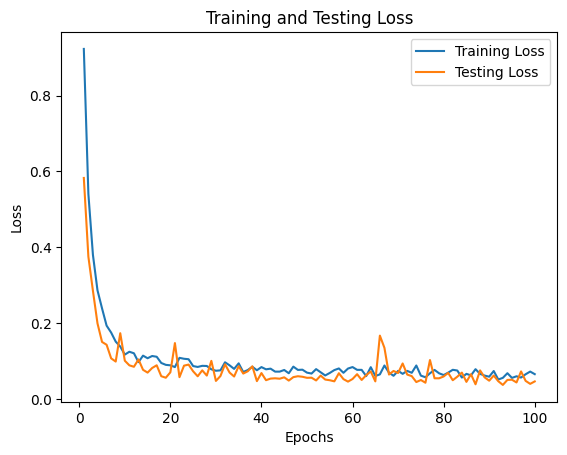

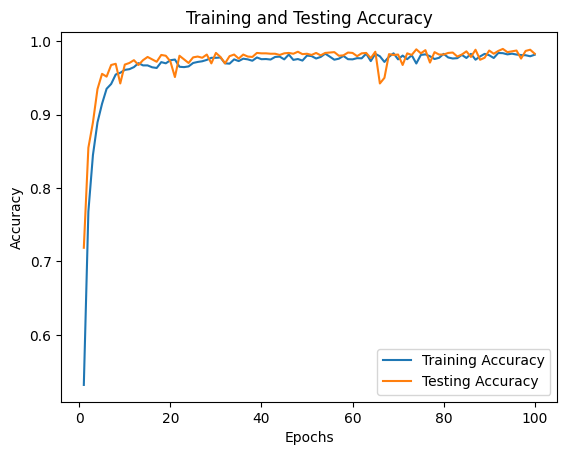

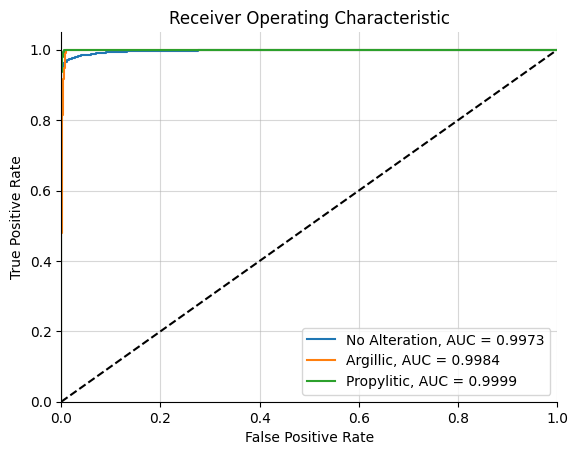

ROC AUC score: 0.9985509166562205


In [8]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Propylitic', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Propylitic']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

367904/367904 [==============================] - 374s 1ms/step


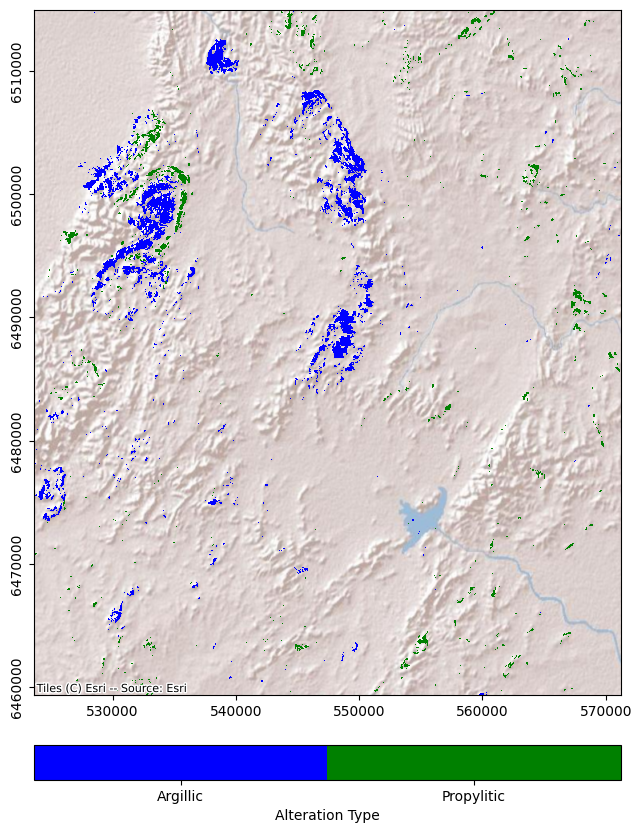

In [9]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

outFile = './Outputs/BrokenHill_ASTER_Manual_CNN_AlterationMap_ks_5.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

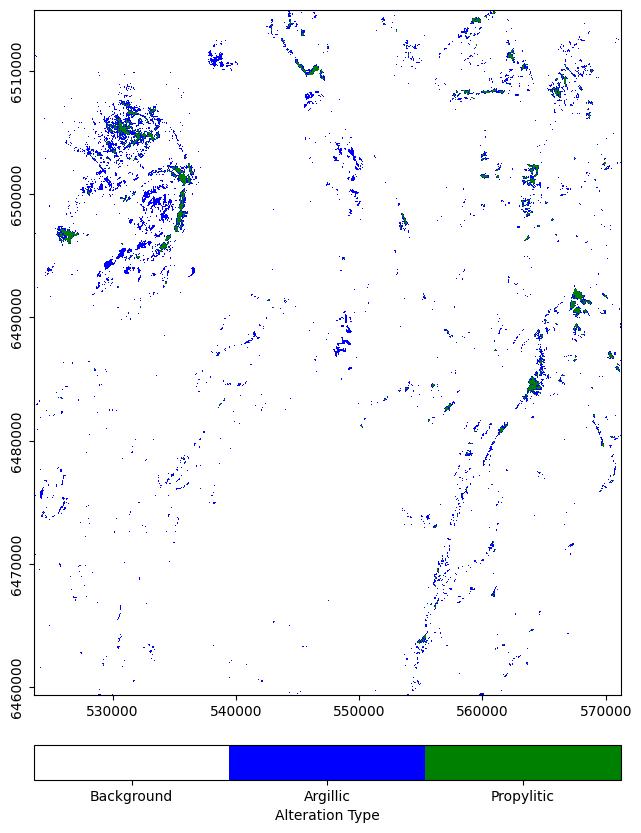

In [10]:
positiveLabel_file = './BrokenHill_ASTER_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [11]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0

### Splitting features and labels into training and test datasets

In [12]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

Epoch 1/50
12873/12873 [==============================] - 526s 41ms/step - loss: 0.3073 - accuracy: 0.8753 - val_loss: 0.1444 - val_accuracy: 0.9470
Epoch 2/50
12873/12873 [==============================] - 522s 41ms/step - loss: 0.1789 - accuracy: 0.9366 - val_loss: 0.0813 - val_accuracy: 0.9727
Epoch 3/50
12873/12873 [==============================] - 529s 41ms/step - loss: 0.1516 - accuracy: 0.9484 - val_loss: 0.1050 - val_accuracy: 0.9649
Epoch 4/50
12873/12873 [==============================] - 528s 41ms/step - loss: 0.1338 - accuracy: 0.9554 - val_loss: 0.0673 - val_accuracy: 0.9788
Epoch 5/50
12873/12873 [==============================] - 532s 41ms/step - loss: 0.1298 - accuracy: 0.9568 - val_loss: 0.0484 - val_accuracy: 0.9861
Epoch 6/50
12873/12873 [==============================] - 529s 41ms/step - loss: 0.1265 - accuracy: 0.9589 - val_loss: 0.0654 - val_accuracy: 0.9810
Epoch 7/50
12873/12873 [==============================] - 451s 35ms/step - loss: 0.1318 - accuracy: 0.9571

5517/5517 [==============================] - 62s 11ms/step
Epoch 1/50
12873/12873 [==============================] - 463s 36ms/step - loss: 0.2901 - accuracy: 0.8833 - val_loss: 0.1352 - val_accuracy: 0.9561
Epoch 2/50
12873/12873 [==============================] - 463s 36ms/step - loss: 0.1689 - accuracy: 0.9413 - val_loss: 0.0987 - val_accuracy: 0.9623
Epoch 3/50
12873/12873 [==============================] - 466s 36ms/step - loss: 0.1465 - accuracy: 0.9500 - val_loss: 0.2617 - val_accuracy: 0.9176
Epoch 4/50
12873/12873 [==============================] - 469s 36ms/step - loss: 0.1294 - accuracy: 0.9569 - val_loss: 0.0641 - val_accuracy: 0.9826
Epoch 5/50
12873/12873 [==============================] - 470s 36ms/step - loss: 0.1296 - accuracy: 0.9577 - val_loss: 0.0663 - val_accuracy: 0.9795
Epoch 6/50
12873/12873 [==============================] - 474s 37ms/step - loss: 0.1264 - accuracy: 0.9594 - val_loss: 0.4549 - val_accuracy: 0.8294
Epoch 7/50
12873/12873 [=======================

Epoch 45/50
12873/12873 [==============================] - 612s 48ms/step - loss: 0.0728 - accuracy: 0.9786 - val_loss: 0.0527 - val_accuracy: 0.9915
Epoch 46/50
12873/12873 [==============================] - 617s 48ms/step - loss: 0.0699 - accuracy: 0.9796 - val_loss: 3.2634 - val_accuracy: 0.6049
Epoch 47/50
12873/12873 [==============================] - 619s 48ms/step - loss: 0.0703 - accuracy: 0.9800 - val_loss: 3.1374 - val_accuracy: 0.6344
Epoch 48/50
12873/12873 [==============================] - 639s 50ms/step - loss: 0.0687 - accuracy: 0.9802 - val_loss: 2.4883 - val_accuracy: 0.6389
Epoch 49/50
12873/12873 [==============================] - 623s 48ms/step - loss: 0.0707 - accuracy: 0.9797 - val_loss: 3.3090 - val_accuracy: 0.6143
Epoch 50/50
5517/5517 [==============================] - 83s 15ms/step
Epoch 1/50
12873/12873 [==============================] - 610s 47ms/step - loss: 0.3258 - accuracy: 0.8678 - val_loss: 0.1419 - val_accuracy: 0.9524
Epoch 2/50
12873/12873 [======

Epoch 42/50
12873/12873 [==============================] - 643s 50ms/step - loss: 0.0898 - accuracy: 0.9738 - val_loss: 2.7379 - val_accuracy: 0.6755
Epoch 43/50
12873/12873 [==============================] - 653s 51ms/step - loss: 0.0889 - accuracy: 0.9742 - val_loss: 1.7405 - val_accuracy: 0.7243
Epoch 44/50
12873/12873 [==============================] - 658s 51ms/step - loss: 0.0855 - accuracy: 0.9749 - val_loss: 2.5295 - val_accuracy: 0.6761
Epoch 45/50
12873/12873 [==============================] - 644s 50ms/step - loss: 0.0858 - accuracy: 0.9746 - val_loss: 2.1725 - val_accuracy: 0.6816
Epoch 46/50
12873/12873 [==============================] - 641s 50ms/step - loss: 0.0864 - accuracy: 0.9747 - val_loss: 3.6754 - val_accuracy: 0.6420
Epoch 47/50
12873/12873 [==============================] - 647s 50ms/step - loss: 0.0874 - accuracy: 0.9742 - val_loss: 2.8579 - val_accuracy: 0.6123
Epoch 48/50
12873/12873 [==============================] - 648s 50ms/step - loss: 0.0867 - accuracy:

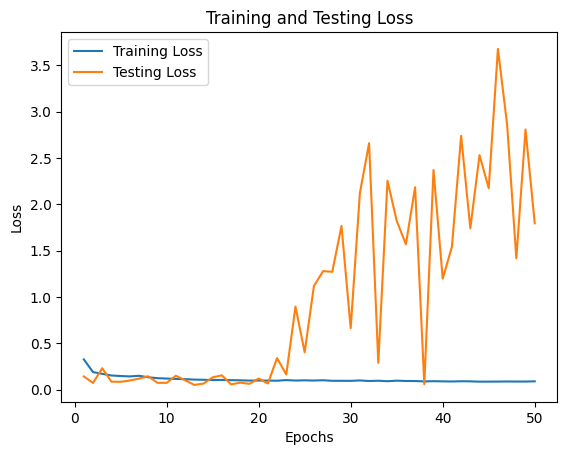

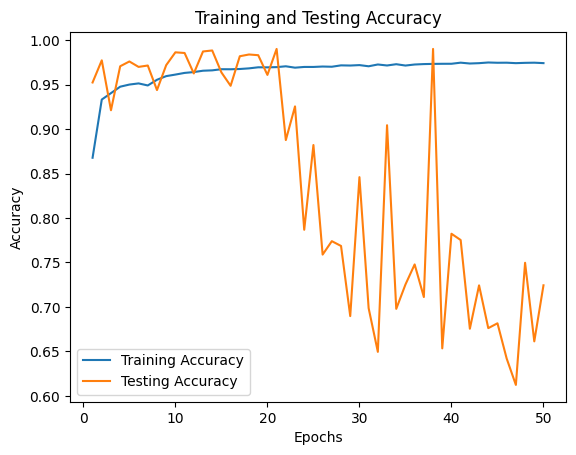

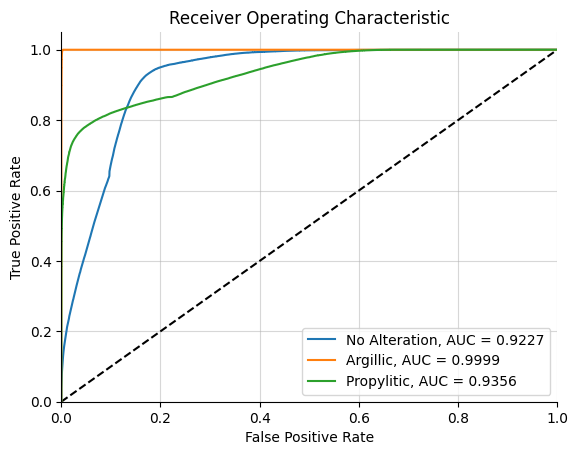

ROC AUC score: 0.9527103414153354


In [13]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 5
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Propylitic', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y))

    for j in range(cv):
        train_x, train_y, test_x, test_y = train_test_split(features, labels)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Propylitic']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

367904/367904 [==============================] - 5898s 16ms/step


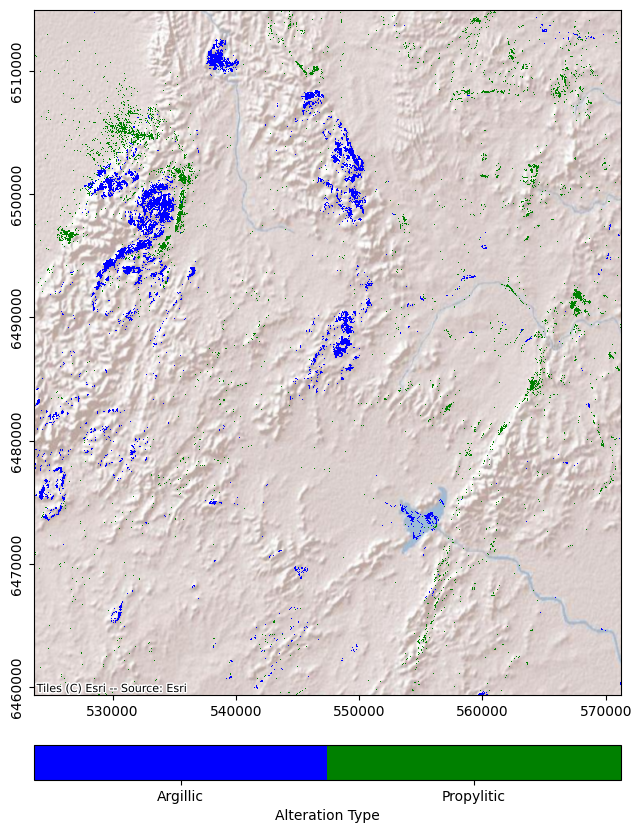

In [14]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

for i in range(arrPred.shape[0]):
    bandMin = arrPred[i, :, :].min()
    bandMax = arrPred[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[1]):
        for k in range(arrPred.shape[2]):
            arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# generate image chips from the array
pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

# predict and export the probability raster
pred = best_model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

outFile = './Outputs/BrokenHill_ASTER_PCA_CNN_AlterationMap_ks_5.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')